In [13]:
import numpy as np
import pandas as pd 
from torchsummary import summary    
import os
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from tqdm import tqdm
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset
import random
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import PIL.Image as Image
import os
from sklearn.metrics import jaccard_score, f1_score
# import wandb
import torchvision
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
from scipy.spatial.distance import directed_hausdorff
import re

In [14]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [15]:
model = torch.hub.load('pytorch/vision:v0.8.0', 'deeplabv3_resnet50', pretrained=True)

# Modify the last convolutional layer
model.classifier[4] = nn.Conv2d(in_channels=256, out_channels=1, kernel_size=(1,1))

# If there's an auxiliary classifier, modify it similarly
if model.aux_classifier is not None:
    model.aux_classifier[4] = nn.Conv2d(in_channels=256, out_channels=1, kernel_size=(1,1))

# load weights into the model 
weights = '/home/dawlat.akaila/Documents/DL_LABS/Cell-Segmentation-in-Hematology-MIL/Segmentation/deeplabv3_leukemia_AR.pth'
model.load_state_dict(torch.load(weights))
model.to(device)

Using cache found in /home/dawlat.akaila/.cache/torch/hub/pytorch_vision_v0.8.0


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [28]:
# Transformation for the input images   
import cv2
resize = 448
transform = A.Compose(
    [
        A.(max_siLongestMaxSizeze=resize),
        A.PadIfNeeded(
            min_height=resize, 
            min_width=resize, 
            border_mode=cv2.BORDER_CONSTANT,
            value=[0, 0, 0]  # Padding with black color for RGB images
        ),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

# Directories
input_folder = '/home/dawlat.akaila/Documents/DL_LABS/PROJECT/DATA&MASKS/val/CML'
output_folder = '/home/dawlat.akaila/Documents/DL_LABS/PROJECT/DATA&MASKS/val_masks/CML'
os.makedirs(output_folder, exist_ok=True)

# Predict masks for images in the input folder
model.eval() 
with torch.no_grad():
    for filename in os.listdir(input_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.tif')):
            img_path = os.path.join(input_folder, filename)
            image = Image.open(img_path).convert("RGB")
            image = np.array(image)

            augmented = transform(image=image)
            input_tensor = augmented["image"].unsqueeze(0).to(device)

            output = model(input_tensor)['out']
            predicted_mask = torch.sigmoid(output).squeeze().cpu().numpy()

            # Convert the predicted mask to binary mask
            binary_mask = (predicted_mask > 0.5).astype(np.uint8) * 255

            # Save the predicted mask
            mask_image = Image.fromarray(binary_mask)
            mask_image.save(os.path.join(output_folder, filename))

print("Mask prediction completed. Masks saved in:", output_folder)

Mask prediction completed. Masks saved in: /home/dawlat.akaila/Documents/DL_LABS/PROJECT/DATA&MASKS/val_masks/CML


In [ ]:
!! 

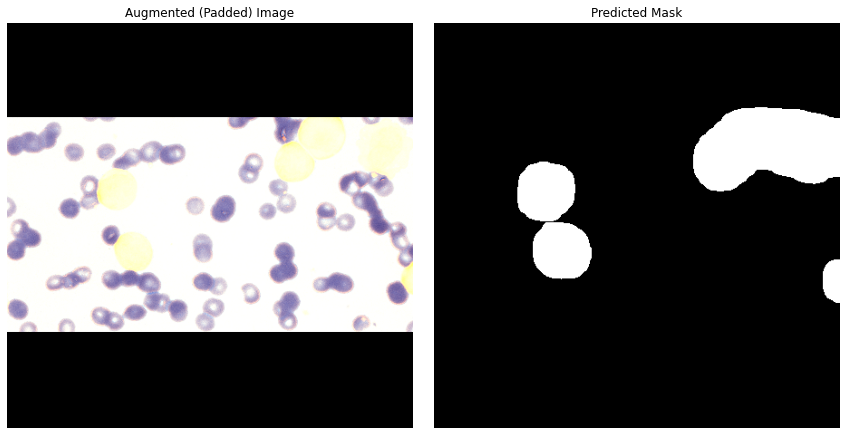

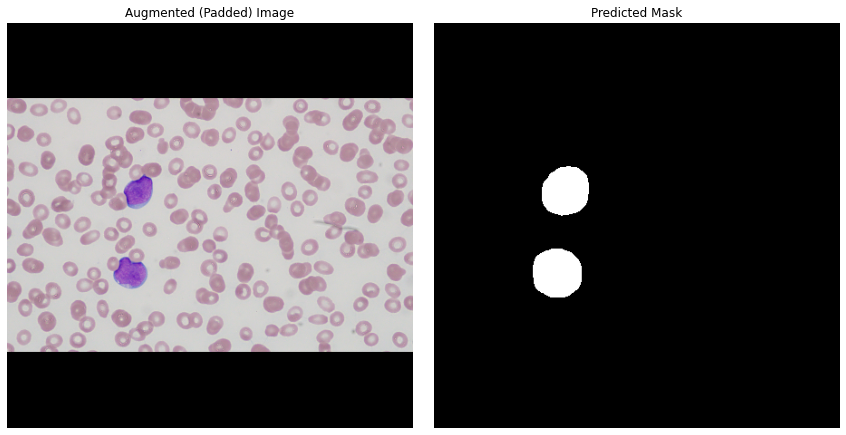

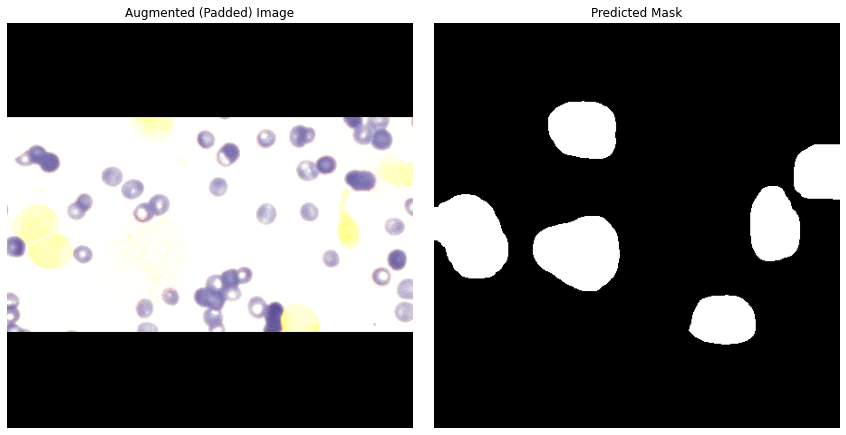

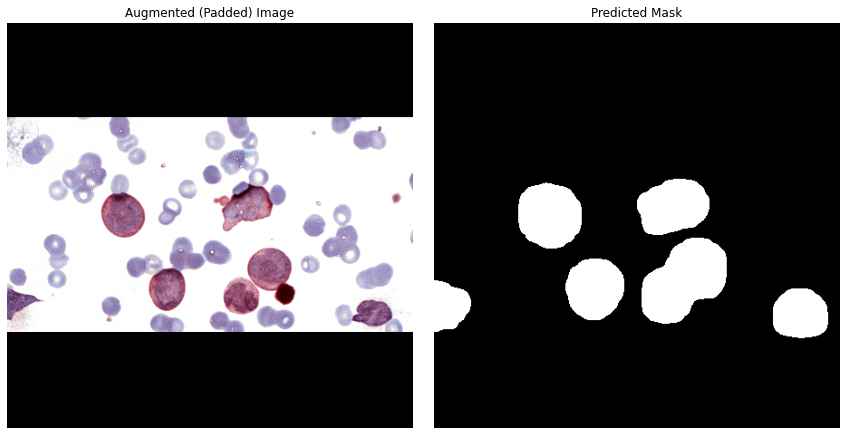

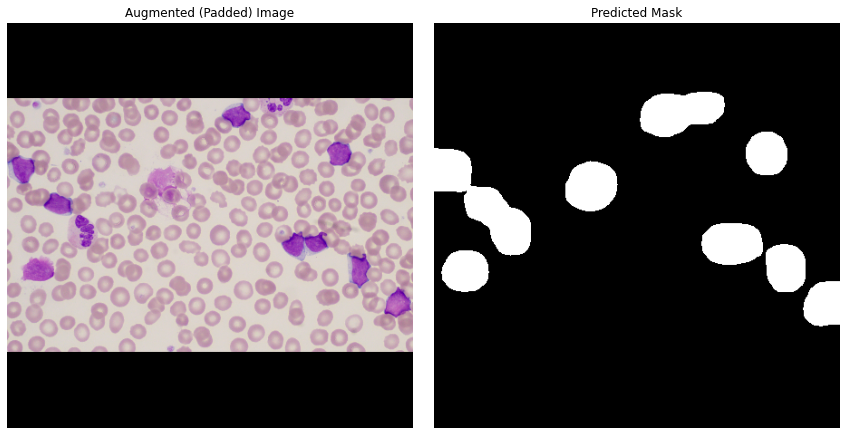

Mask prediction completed. Masks saved in: /home/dawlat.akaila/Documents/DL_LABS/PROJECT/try_masks


In [17]:
import torch
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import matplotlib.pyplot as plt

# Assuming model, device, etc., are already set up earlier in your script

def plot_image_and_mask(image, mask):
    # Assuming image is already in the correct format (H, W, C)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image)
    axes[0].set_title('Augmented (Padded) Image')
    axes[0].axis('off')
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

# Directory setup
input_folder = '/home/dawlat.akaila/Documents/DL_LABS/PROJECT/try'
output_folder = '/home/dawlat.akaila/Documents/DL_LABS/PROJECT/try_masks'
os.makedirs(output_folder, exist_ok=True)

model.eval()  # Ensure model is in eval mode

with torch.no_grad():
    for filename in os.listdir(input_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.tif')):
            img_path = os.path.join(input_folder, filename)
            image = Image.open(img_path).convert("RGB")
            image_np = np.array(image)  # Convert to numpy array for processing
            
            # Apply transformations
            augmented = transform(image=image_np)
            padded_image = augmented['image'].numpy()  # Extract the padded image
            input_tensor = augmented["image"].unsqueeze(0).to(device)  # Prepare tensor for model
            
            # Model prediction
            output = model(input_tensor)['out']
            predicted_mask = torch.sigmoid(output).squeeze().cpu().numpy() > 0.5
            binary_mask = (predicted_mask).astype(np.uint8) * 255
            
            # Plot the results
            plot_image_and_mask(np.transpose(padded_image, (1, 2, 0)), binary_mask)  # Ensure padded_image is (H, W, C)
            
            # Save the predicted mask
            mask_image = Image.fromarray(binary_mask * 255)  # Convert binary mask to 255 scale if needed
            mask_image.save(os.path.join(output_folder, filename))

print("Mask prediction completed. Masks saved in:", output_folder)


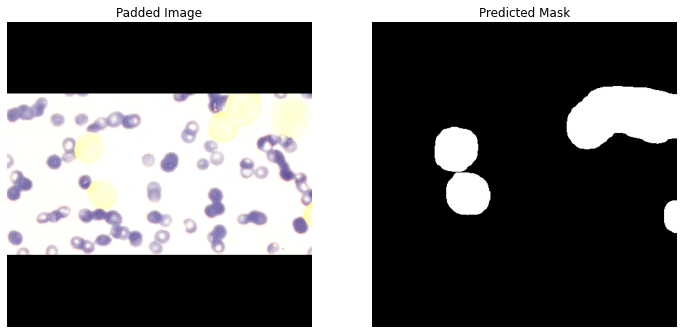

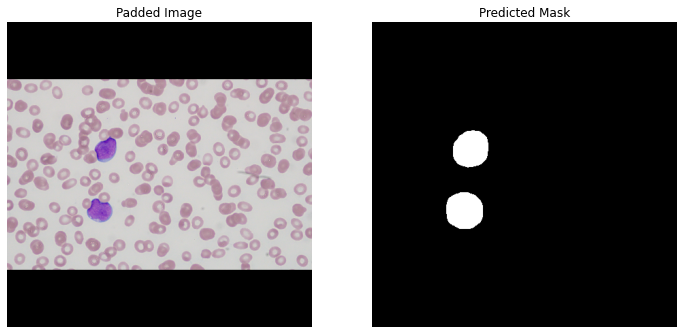

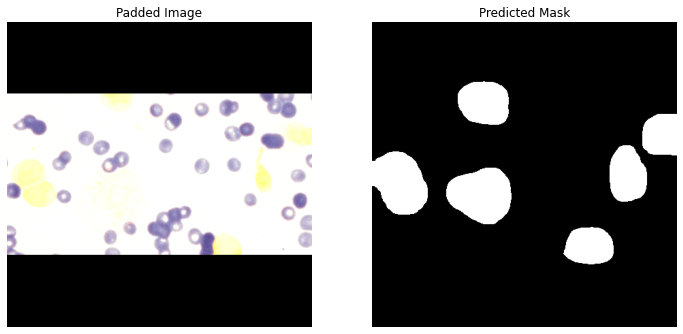

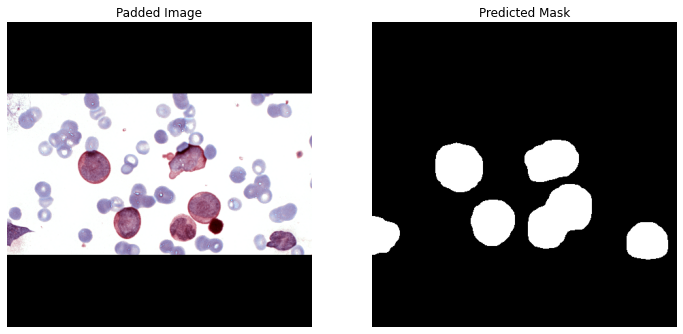

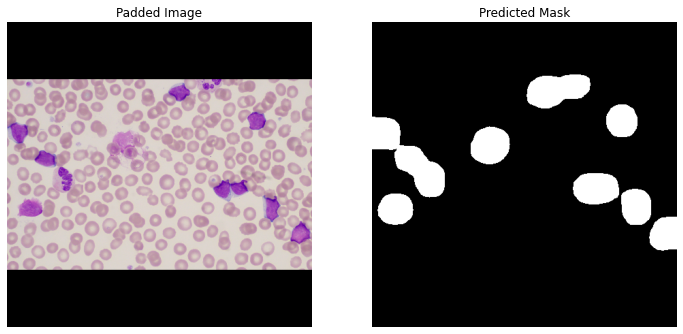

Mask prediction completed. Masks saved in: /home/dawlat.akaila/Documents/DL_LABS/PROJECT/try_masks


In [18]:
import os
import numpy as np
from PIL import Image
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt

# Transformation for the input images
resize = 448

def pad_to_square(image, target_size):
    height, width = image.shape[:2]
    delta_w = target_size - width
    delta_h = target_size - height
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    color = [0, 0, 0]
    new_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return new_image

transform = A.Compose(
    [
        A.LongestMaxSize(max_size=resize),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ])

# Directories
input_folder = '/home/dawlat.akaila/Documents/DL_LABS/PROJECT/try'
output_folder = '/home/dawlat.akaila/Documents/DL_LABS/PROJECT/try_masks'
os.makedirs(output_folder, exist_ok=True)

# Predict masks for images in the input folder
model.eval()
with torch.no_grad():
    for filename in os.listdir(input_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.tif')):
            img_path = os.path.join(input_folder, filename)
            image = Image.open(img_path).convert("RGB")
            image = np.array(image)

            augmented = transform(image=image)
            image_np = augmented["image"].numpy().transpose(1, 2, 0)
            padded_image = pad_to_square(image_np, resize)
            input_tensor = torch.tensor(padded_image).permute(2, 0, 1).unsqueeze(0).to(device)

            output = model(input_tensor)['out']
            predicted_mask = torch.sigmoid(output).squeeze().cpu().numpy()

            # Convert the predicted mask to binary mask
            binary_mask = (predicted_mask > 0.5).astype(np.uint8) * 255

            # Save the predicted mask
            mask_image = Image.fromarray(binary_mask)
            mask_image.save(os.path.join(output_folder, filename))

            # Plot the padded image and the predicted mask
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.title('Padded Image')
            plt.imshow(padded_image)
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.title('Predicted Mask')
            plt.imshow(binary_mask, cmap='gray')
            plt.axis('off')

            plt.show()

print("Mask prediction completed. Masks saved in:", output_folder)
